
This notebook contains the code used in the BigComp 2022 paper: <br>
<b>Heeryon Cho, Woo-Kyu Kang, Younsoo Park, Sungeu Chae, and Seong-joon Kim, "Multi-label Facial Emotion Recognition Using Korean Drama Movie Clips," BigComp 2022.</b>
### Autoencoder /  Classify Multi-label Emotions

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os

In [2]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Record cell run time.
#!pip install ipython-autotime

%load_ext autotime

time: 514 µs (started: 2021-12-07 07:56:48 +00:00)


In [4]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 1.79 ms (started: 2021-12-07 07:56:48 +00:00)


### Load pretrained autoencoder.

In [5]:
# Create autoencoder model (skeleton) for loading pretrained weights.

def create_autoencoder():
    # Define the model
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #2nd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

    #3rd convolution layer
    model.add(Conv2D(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))    

    #1st deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    #2nd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))

    #3rd deconvolution layer
    model.add(Conv2DTranspose(32,(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))    

    model.add(Conv2D(3,(3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.summary()
    
    return model

time: 5.04 ms (started: 2021-12-07 07:56:48 +00:00)


In [6]:
# Load pretrained autoencoder weights.

checkpoint_path = "./model/autoencoder.ckpt"
autoencoder = create_autoencoder()
autoencoder.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

time: 1.76 s (started: 2021-12-07 07:56:48 +00:00)


### The below code is for creating training data tfrecord and idx file from images. (We do not use the below code in this jupyter notebook since we import tfrecords directly.)

```python
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

from itertools import islice
from subprocess import call

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#def _float_feature(value):
#    """Returns a float_list from a float / double."""
#    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    if type(value) != list:
        value = [value]
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# Create a dictionary with relevant features.

def image_example(image_string, label):
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def gen_tfrecord_idx(tfrecord_file, dict_label, tfrecord_idx):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in dict_label.items():
            fname = "./image/" + filename
            image_string = open(fname, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())

    tfrecord2idx_script = "tfrecord2idx"

    if not os.path.isfile(tfrecord_idx):
        call([tfrecord2idx_script, tfrecord_file, tfrecord_idx])


#--------------------------------------------
# VALID DATA: Load labels, check headers, check data shape.

df_label_valid = pd.read_csv('label/label_multi-label_valid.csv')
print("valid columns:", df_label_valid.columns)
print("valid shape:", df_label_valid.shape)

# Place labels into a dictionary.

dict_label_valid = {}
for idx, row in df_label_valid.iterrows():
    dict_label_valid[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_valid)

#--------------------------------------------
# Create VALID tfrecord & idx files from jpg images.

tfrecord_file_valid = './tfrecords/multi-label_valid.tfrecords'
tfrecord_idx_valid = './tfrecords/multi-label_valid.idx'

gen_tfrecord_idx(tfrecord_file_valid, dict_label_valid, tfrecord_idx_valid)

#--------------------------------------------
# TRAIN DATA: Load labels, check headers, check data shape.

df_label_train = pd.read_csv('label/label_multi-label_train.csv')
print("train columns:", df_label_train.columns)
print("train shape:", df_label_train.shape)

# Place labels into a dictionary.

dict_label_train = {}
for idx, row in df_label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_train)

#--------------------------------------------
# Create TRAIN tfrecord & idx files from jpg images.

tfrecord_file_train = './tfrecords/multi-label_train.tfrecords'
tfrecord_idx_train = './tfrecords/multi-label_train.idx'

gen_tfrecord_idx(tfrecord_file_train, dict_label_train, tfrecord_idx_train) 

#--------------------------------------------
# TEST DATA: Load labels, check headers, check data shape.

df_label_test = pd.read_csv('label/label_multi-label_test.csv')
print("test columns:", df_label_test.columns)
print("test shape:", df_label_test.shape)

# Place labels into a dictionary.

dict_label_test = {}
for idx, row in df_label_test.iterrows():
    dict_label_test[row['img_id']] = list(row['moved':'disgusted'].values)
len(dict_label_test)

#-------------------------------------------
# Create TEST tfrecord & idx files from jpg images.

tfrecord_file_test = './tfrecords/multi-label_test.tfrecords'
tfrecord_idx_test = './tfrecords/multi-label_test.idx'

gen_tfrecord_idx(tfrecord_file_test, dict_label_test, tfrecord_idx_test) 

# OUTPUT
# valid columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# valid shape: (3882, 26)
# train columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# train shape: (31053, 26)
# test columns: Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
#       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
#       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
#       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
#       'happy', 'disgusted'],
#       dtype='object')
# test shape: (3882, 26)
```    

### Load label data.

In [8]:
# Load labels, check headers, check data shape.

df_label = pd.read_csv('label/label_multi-label.csv')
print(df_label.columns)
print(df_label.shape)

LABELS = list(df_label.columns[2:])
print("LABELS=", LABELS)
print("All classes:", len(LABELS))

label_valid = pd.read_csv('label/label_multi-label_valid.csv')
label_train = pd.read_csv('label/label_multi-label_train.csv')
label_test = pd.read_csv('label/label_multi-label_test.csv')

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", label_train.shape[0])
print("VALID_DATA_SIZE:", label_valid.shape[0])
print("TEST_DATA_SIZE:", label_test.shape[0])

Index(['img_id', 'clip_id', 'moved', 'fearful', 'bored', 'surprised', 'angry',
       'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled',
       'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed',
       'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful',
       'happy', 'disgusted'],
      dtype='object')
(38817, 26)
LABELS= ['moved', 'fearful', 'bored', 'surprised', 'angry', 'anxious', 'smitten', 'fluttered', 'disappointed', 'fulfilled', 'ashamed', 'sad', 'upset', 'sympathetic', 'passionate', 'depressed', 'amused', 'affectionate', 'guilty', 'neutral', 'jealous', 'peaceful', 'happy', 'disgusted']
All classes: 24
TRAIN_DATA_SIZE: 31053
VALID_DATA_SIZE: 3882
TEST_DATA_SIZE: 3882
time: 159 ms (started: 2021-12-07 07:57:12 +00:00)


### Define training pipeline.

In [9]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.plugin.tf as dali_tf

class TFRecordPipelineTrain(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTrain, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_train.tfrecords'],
             index_path = ['./tfrecords/multi-label_train.idx'],
             random_shuffle=True,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 87.8 ms (started: 2021-12-07 07:57:12 +00:00)


### Define validation pipeline.

In [10]:
class TFRecordPipelineValid(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineValid, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_valid.tfrecords'],
             index_path = ['./tfrecords/multi-label_valid.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.91 ms (started: 2021-12-07 07:57:12 +00:00)


### Train autoencoder model for classifying multi-label emotions.

In [11]:
if __name__ == "__main__":
    batch_size = 64
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_train = TFRecordPipelineTrain(batch_size=batch_size, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)

    batch_size_valid = 64
    shapes_valid = ((batch_size_valid, 64, 64, 3),
                    (batch_size_valid, 24))
    pipe_valid = TFRecordPipelineValid(batch_size=batch_size_valid, 
                                 num_threads=1, 
                                 device='gpu', 
                                 device_id=0)       

    with tf.device('/gpu:0'):
        ds_train = dali_tf.DALIDataset(
            pipeline=pipe_train,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        
        ds_valid = dali_tf.DALIDataset(
            pipeline=pipe_valid,
            batch_size=batch_size_valid,
            output_shapes=shapes_valid,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)             
        
        initializer = keras.initializers.GlorotUniform(seed=set_seed)
        activation =  keras.activations.sigmoid
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // batch_size * 10,
            decay_rate=0.95)
        
        number_of_classes = 24
        
        inputs = keras.Input(shape=(64, 64, 3))
        x = autoencoder(inputs, training=False)   # Fix autoencoder weights.
        flat = keras.layers.Flatten()(x)
        fc1 = keras.layers.Dense(number_of_classes, activation='relu',
                             kernel_initializer=initializer)(flat)
        do1 = keras.layers.Dropout(0.5, seed=set_seed)(fc1)
        outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(do1) 
        clf = keras.Model(inputs, outputs)
        
        clf.summary()

        # To save the model weights, uncomment the below code.        
        #checkpoint_path = "./model/cp_clf_multi-label.ckpt"
        #checkpoint_dir = os.path.dirname(checkpoint_path)
        #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                         save_weights_only=True,
        #                                         verbose=1)

        # Apply early stopping.        
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)  
        
        clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
        
        history = clf.fit(ds_train, steps_per_epoch=TRAIN_DATA_SIZE // batch_size, 
                          validation_data=ds_valid.take(VALID_DATA_SIZE // batch_size_valid),
                          epochs=1000,
                          callbacks=[es_callback]) 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         48003     
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 24)                294936    
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 343,539
Trainable params: 343,539
Non-trainable params: 0
_______________________________________________________

485/485 [==============================] - 7s 15ms/step - loss: 0.2326 - accuracy: 0.2074 - val_loss: 0.1863 - val_accuracy: 0.3247
Epoch 50/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.2307 - accuracy: 0.2163 - val_loss: 0.1861 - val_accuracy: 0.3260
Epoch 51/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.2297 - accuracy: 0.2188 - val_loss: 0.1855 - val_accuracy: 0.3279
Epoch 52/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.2281 - accuracy: 0.2201 - val_loss: 0.1852 - val_accuracy: 0.3266
Epoch 53/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.2279 - accuracy: 0.2242 - val_loss: 0.1850 - val_accuracy: 0.3323
Epoch 54/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.2263 - accuracy: 0.2284 - val_loss: 0.1843 - val_accuracy: 0.3318
Epoch 55/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.2251 - accuracy: 0.2346 - val_loss: 0.1841 - val_accuracy:

485/485 [==============================] - 7s 15ms/step - loss: 0.2010 - accuracy: 0.3175 - val_loss: 0.1742 - val_accuracy: 0.3789
Epoch 106/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1998 - accuracy: 0.3200 - val_loss: 0.1741 - val_accuracy: 0.3799
Epoch 107/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.2003 - accuracy: 0.3161 - val_loss: 0.1744 - val_accuracy: 0.3781
Epoch 108/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1998 - accuracy: 0.3191 - val_loss: 0.1738 - val_accuracy: 0.3878
Epoch 109/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.2000 - accuracy: 0.3175 - val_loss: 0.1738 - val_accuracy: 0.3859
Epoch 110/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1998 - accuracy: 0.3211 - val_loss: 0.1736 - val_accuracy: 0.3891
Epoch 111/1000
485/485 [==============================] - 7s 14ms/step - loss: 0.1993 - accuracy: 0.3214 - val_loss: 0.1736 - val_acc

Epoch 161/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1912 - accuracy: 0.3390 - val_loss: 0.1686 - val_accuracy: 0.4052
Epoch 162/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1910 - accuracy: 0.3404 - val_loss: 0.1686 - val_accuracy: 0.4115
Epoch 163/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1910 - accuracy: 0.3394 - val_loss: 0.1680 - val_accuracy: 0.4089
Epoch 164/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1910 - accuracy: 0.3388 - val_loss: 0.1680 - val_accuracy: 0.4068
Epoch 165/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1905 - accuracy: 0.3399 - val_loss: 0.1680 - val_accuracy: 0.4130
Epoch 166/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1908 - accuracy: 0.3353 - val_loss: 0.1678 - val_accuracy: 0.4102
Epoch 167/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1911 - accuracy: 0.3400 - val_loss: 0

Epoch 217/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1858 - accuracy: 0.3487 - val_loss: 0.1645 - val_accuracy: 0.4216
Epoch 218/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1857 - accuracy: 0.3484 - val_loss: 0.1640 - val_accuracy: 0.4281
Epoch 219/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1860 - accuracy: 0.3455 - val_loss: 0.1644 - val_accuracy: 0.4245
Epoch 220/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1857 - accuracy: 0.3492 - val_loss: 0.1636 - val_accuracy: 0.4307
Epoch 221/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1853 - accuracy: 0.3474 - val_loss: 0.1641 - val_accuracy: 0.4260
Epoch 222/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1853 - accuracy: 0.3525 - val_loss: 0.1635 - val_accuracy: 0.4258
Epoch 223/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1857 - accuracy: 0.3492 - val_loss: 0

Epoch 273/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1819 - accuracy: 0.3545 - val_loss: 0.1607 - val_accuracy: 0.4346
Epoch 274/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1828 - accuracy: 0.3536 - val_loss: 0.1608 - val_accuracy: 0.4354
Epoch 275/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1823 - accuracy: 0.3526 - val_loss: 0.1605 - val_accuracy: 0.4365
Epoch 276/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1819 - accuracy: 0.3542 - val_loss: 0.1608 - val_accuracy: 0.4352
Epoch 277/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1824 - accuracy: 0.3517 - val_loss: 0.1605 - val_accuracy: 0.4372
Epoch 278/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1820 - accuracy: 0.3543 - val_loss: 0.1605 - val_accuracy: 0.4401
Epoch 279/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1818 - accuracy: 0.3574 - val_loss: 0

Epoch 329/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1793 - accuracy: 0.3598 - val_loss: 0.1583 - val_accuracy: 0.4422
Epoch 330/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1788 - accuracy: 0.3620 - val_loss: 0.1587 - val_accuracy: 0.4388
Epoch 331/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1790 - accuracy: 0.3582 - val_loss: 0.1588 - val_accuracy: 0.4406
Epoch 332/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1799 - accuracy: 0.3597 - val_loss: 0.1582 - val_accuracy: 0.4430
Epoch 333/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1798 - accuracy: 0.3621 - val_loss: 0.1584 - val_accuracy: 0.4411
Epoch 334/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1789 - accuracy: 0.3619 - val_loss: 0.1582 - val_accuracy: 0.4419
Epoch 335/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1795 - accuracy: 0.3595 - val_loss: 0

Epoch 385/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1778 - accuracy: 0.3609 - val_loss: 0.1567 - val_accuracy: 0.4471
Epoch 386/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1781 - accuracy: 0.3625 - val_loss: 0.1568 - val_accuracy: 0.4458
Epoch 387/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1776 - accuracy: 0.3634 - val_loss: 0.1568 - val_accuracy: 0.4461
Epoch 388/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1773 - accuracy: 0.3634 - val_loss: 0.1567 - val_accuracy: 0.4471
Epoch 389/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1772 - accuracy: 0.3631 - val_loss: 0.1569 - val_accuracy: 0.4458
Epoch 390/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1770 - accuracy: 0.3645 - val_loss: 0.1565 - val_accuracy: 0.4492
Epoch 391/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1773 - accuracy: 0.3637 - val_loss: 0

Epoch 441/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1756 - accuracy: 0.3637 - val_loss: 0.1555 - val_accuracy: 0.4497
Epoch 442/1000
485/485 [==============================] - 8s 16ms/step - loss: 0.1762 - accuracy: 0.3664 - val_loss: 0.1555 - val_accuracy: 0.4477
Epoch 443/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1757 - accuracy: 0.3657 - val_loss: 0.1554 - val_accuracy: 0.4490
Epoch 444/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1765 - accuracy: 0.3628 - val_loss: 0.1556 - val_accuracy: 0.4471
Epoch 445/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1764 - accuracy: 0.3664 - val_loss: 0.1556 - val_accuracy: 0.4492
Epoch 446/1000
485/485 [==============================] - 7s 15ms/step - loss: 0.1762 - accuracy: 0.3658 - val_loss: 0.1556 - val_accuracy: 0.4490
time: 55min 42s (started: 2021-12-07 07:57:12 +00:00)


In [12]:
# List all data in history.

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
time: 685 µs (started: 2021-12-07 08:52:55 +00:00)


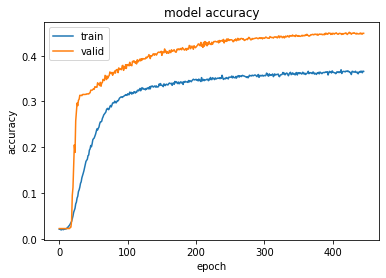

time: 176 ms (started: 2021-12-07 08:52:55 +00:00)


In [13]:
# Summarize history for accuracy.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

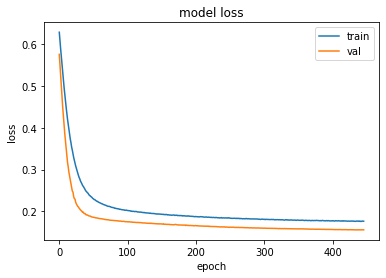

time: 121 ms (started: 2021-12-07 08:52:55 +00:00)


In [14]:
# Summarize history for loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Define test pipeline.

In [15]:
class TFRecordPipelineTest(Pipeline):
    def __init__(self, batch_size, num_threads,
                 device = 'cpu', device_id = 0):
        super(TFRecordPipelineTest, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = fn.readers.tfrecord(        
             features = {"image_raw": tfrec.FixedLenFeature((), tfrec.string, ""),
                         "label": tfrec.FixedLenFeature([24], tfrec.int64,  24)},
             path = ['./tfrecords/multi-label_test.tfrecords'],
             index_path = ['./tfrecords/multi-label_test.idx'],
             random_shuffle=False,
             seed = set_seed)
        self.iter = 0
    def define_graph(self):
        inputs = self.input
        images = fn.decoders.image(inputs["image_raw"], device = "mixed", output_type = types.RGB) / 255.
        labels = inputs["label"].gpu()
        return (images, labels)
    def iter_setup(self):
        pass

time: 1.76 ms (started: 2021-12-07 08:52:55 +00:00)


### Check test data accuracy.

In [16]:
# https://docs.nvidia.com/deeplearning/dali/user-guide/docs/plugins/tensorflow_plugin_api.html

if __name__ == "__main__":
    batch_size = 1
    shapes = ((batch_size, 64, 64, 3),
              (batch_size, 24))
    pipe_test = TFRecordPipelineTest(batch_size=batch_size, 
                            num_threads=4, 
                            device='gpu', 
                            device_id=0)

    with tf.device('/gpu:0'):
        ds_test = dali_tf.DALIDataset(
            pipeline=pipe_test,
            batch_size=batch_size,
            output_shapes=shapes,
            output_dtypes=(tf.float32, tf.int64),
            device_id=0)
        print(ds_test)
        loss, acc = clf.evaluate(ds_test, steps=TEST_DATA_SIZE)
        print("Test accuracy:", acc)
        predictions = clf.predict(ds_test.take(5))
        print("A test output from the last layer:", predictions[0])
        print("Index of the maximum value:", np.argmax(predictions[0]))
        print("Label:", LABELS[np.argmax(predictions[0])])

<DALIDataset shapes: ((1, 64, 64, 3), (1, 24)), types: (tf.float32, tf.int64)>
3882/3882 [==============================] - 25s 6ms/step - loss: 0.1529 - accuracy: 0.4521
Test accuracy: 0.45208656787872314
A test output from the last layer: [4.97866375e-03 4.76069329e-03 7.21763627e-06 2.76316609e-02
 1.47206143e-01 1.14300298e-02 1.91663653e-02 6.11027330e-03
 5.30611500e-02 5.82297565e-04 1.20043079e-03 4.27489340e-01
 2.90657669e-01 1.02416342e-02 2.09215563e-04 2.85320133e-01
 1.34798866e-02 6.20697811e-03 3.35003324e-02 2.25526856e-06
 1.18627185e-02 1.37504668e-03 2.10635681e-02 9.10601392e-03]
Index of the maximum value: 11
Label: sad
time: 25.8 s (started: 2021-12-07 08:52:55 +00:00)


In [17]:
predictions

array([[4.97866375e-03, 4.76069329e-03, 7.21763627e-06, 2.76316609e-02,
        1.47206143e-01, 1.14300298e-02, 1.91663653e-02, 6.11027330e-03,
        5.30611500e-02, 5.82297565e-04, 1.20043079e-03, 4.27489340e-01,
        2.90657669e-01, 1.02416342e-02, 2.09215563e-04, 2.85320133e-01,
        1.34798866e-02, 6.20697811e-03, 3.35003324e-02, 2.25526856e-06,
        1.18627185e-02, 1.37504668e-03, 2.10635681e-02, 9.10601392e-03],
       [2.33942457e-03, 6.36320282e-03, 2.23064626e-06, 4.88715731e-02,
        3.13298017e-01, 6.54345527e-02, 5.04365703e-03, 2.64642597e-03,
        4.97062504e-02, 9.29505855e-04, 3.00723780e-03, 3.37863684e-01,
        1.58388063e-01, 1.87594164e-02, 7.81154667e-04, 7.35167740e-03,
        5.14083542e-03, 9.08293854e-03, 2.37024613e-02, 5.50549828e-07,
        3.47494637e-03, 4.30327316e-04, 3.95914726e-03, 7.50057865e-03],
       [1.74020324e-03, 1.59519585e-03, 5.28972578e-07, 2.86435261e-02,
        4.98671025e-01, 1.95824411e-02, 9.40034818e-03, 2.1288

time: 3.96 ms (started: 2021-12-07 08:53:21 +00:00)


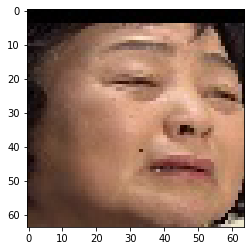

time: 203 ms (started: 2021-12-07 08:55:53 +00:00)


In [19]:
# Display the tested image.

import matplotlib.pyplot as plt

data, = ds_test.take(1)
plt.imshow(data[0][0])

In [20]:
# Check the test data's true label.
data[1]

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])>

time: 5.47 ms (started: 2021-12-07 08:55:58 +00:00)


### Result: Argmax Accuracy & Micro F1-score

In [21]:
pred_test = clf.predict(ds_test.take(TEST_DATA_SIZE))

time: 14.8 s (started: 2021-12-07 08:59:10 +00:00)


In [22]:
true_test = np.concatenate([y for x, y in ds_test.take(TEST_DATA_SIZE)], axis=0)

time: 1.41 s (started: 2021-12-07 08:59:25 +00:00)


In [23]:
true_test.shape

(3882, 24)

time: 2.47 ms (started: 2021-12-07 08:59:26 +00:00)


In [49]:
from sklearn.metrics import accuracy_score, f1_score

true_test_ls = []
pred_test_ls = []

for (true, pred) in zip(true_test, pred_test):
    true_test_ls.append(np.argmax(true))
    pred_test_ls.append(np.argmax(pred))

argmax_acc = accuracy_score(true_test_ls, pred_test_ls)
f1_micro = f1_score(true_test_ls, pred_test_ls, average='micro')

print("argmax accuracy:", argmax_acc)
print("f1_micro:", f1_micro)

argmax accuracy: 0.4520865533230294
f1_micro: 0.4520865533230294
time: 42.6 ms (started: 2021-12-07 10:06:11 +00:00)


### Result: Threshold=0.5 Accuracy & Micro F1-score

In [33]:
pred_05 = pred_test.copy()
pred_05

array([[4.9786638e-03, 4.7606933e-03, 7.2176363e-06, ..., 1.3750467e-03,
        2.1063568e-02, 9.1060139e-03],
       [2.3394246e-03, 6.3632028e-03, 2.2306463e-06, ..., 4.3032732e-04,
        3.9591473e-03, 7.5005786e-03],
       [1.7402032e-03, 1.5951958e-03, 5.2897258e-07, ..., 1.2674864e-03,
        2.0134753e-02, 9.0431208e-03],
       ...,
       [2.2252165e-03, 1.2714493e-03, 7.7269368e-07, ..., 5.8910291e-04,
        5.5705383e-02, 7.7449684e-03],
       [2.1054752e-02, 8.6373277e-02, 2.2031080e-04, ..., 1.3285727e-02,
        5.3196408e-02, 3.6972877e-02],
       [4.2888816e-03, 3.2100773e-03, 3.0633742e-06, ..., 6.5450324e-04,
        4.1614600e-02, 7.1101971e-03]], dtype=float32)

time: 7.13 ms (started: 2021-12-07 09:29:40 +00:00)


In [50]:
for ls in pred_05:
    thres = 0.5
    pred_05[pred_05 >= thres] = 1
    pred_05[pred_05 < thres] = 0
pred_05[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 706 ms (started: 2021-12-07 10:11:06 +00:00)


In [51]:
accuracy_score(true_test, pred_05)

0.1056156620298815

time: 17.6 ms (started: 2021-12-07 10:11:08 +00:00)


In [52]:
f1_score(true_test, pred_05, average='micro')

0.22344704305079693

time: 27.9 ms (started: 2021-12-07 10:11:10 +00:00)


### Result: Threshold=0.4 Accuracy & Micro F1-score

In [53]:
pred_04 = pred_test.copy()
for ls in pred_04:
    thres = 0.4
    pred_04[pred_04 >= thres] = 1
    pred_04[pred_04 < thres] = 0
pred_04[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 840 ms (started: 2021-12-07 10:11:42 +00:00)


In [54]:
accuracy_score(true_test, pred_04)

0.18985059247810407

time: 18.6 ms (started: 2021-12-07 10:11:44 +00:00)


In [55]:
f1_score(true_test, pred_04, average='micro')

0.35739367928209126

time: 25.9 ms (started: 2021-12-07 10:11:45 +00:00)


### Result: Threshold=0.3 Accuracy & Micro F1-score

In [56]:
pred_03 = pred_test.copy()
for ls in pred_03:
    thres = 0.3
    pred_03[pred_03 >= thres] = 1
    pred_03[pred_03 < thres] = 0
pred_03[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.06 s (started: 2021-12-07 10:12:14 +00:00)


In [57]:
accuracy_score(true_test, pred_03)

0.24059763008758372

time: 18.4 ms (started: 2021-12-07 10:12:16 +00:00)


In [58]:
f1_score(true_test, pred_03, average='micro')

0.4565083281924737

time: 28.5 ms (started: 2021-12-07 10:12:17 +00:00)


### Result: Threshold=0.2 Accuracy & Micro F1-score

In [59]:
pred_02 = pred_test.copy()
for ls in pred_02:
    thres = 0.2
    pred_02[pred_02 >= thres] = 1
    pred_02[pred_02 < thres] = 0
pred_02[0] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.33 s (started: 2021-12-07 10:12:41 +00:00)


In [60]:
accuracy_score(true_test, pred_02)

0.19860896445131376

time: 19.2 ms (started: 2021-12-07 10:12:43 +00:00)


In [61]:
f1_score(true_test, pred_02, average='micro')

0.4860845236342217

time: 29.6 ms (started: 2021-12-07 10:12:44 +00:00)


### Result: Threshold=0.1 Accuracy & Micro F1-score

In [65]:
pred_01 = pred_test.copy()
for ls in pred_01:
    thres = 0.1
    pred_01[pred_01 >= thres] = 1
    pred_01[pred_01 < thres] = 0
pred_01[0] 

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

time: 1.68 s (started: 2021-12-07 10:13:18 +00:00)


In [66]:
accuracy_score(true_test, pred_01)

0.021895929933024215

time: 19.3 ms (started: 2021-12-07 10:13:21 +00:00)


In [67]:
f1_score(true_test, pred_01, average='micro')

0.4100854154295893

time: 30.8 ms (started: 2021-12-07 10:13:21 +00:00)
